# Elo Merchant Category Recommendation - LightGBM
End date: _2019. february 19._<br/>

This tutorial notebook is the second part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import os
import gc
import math
import random
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

random.seed(1)
threshold = 0.5

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Data loading
### Train and test data

In [4]:
df_train = pd.read_csv("preprocessed/train_parsed.csv")
df_train = reduce_mem_usage(df_train)

df_test = pd.read_csv("preprocessed/test_parsed.csv")
df_test = reduce_mem_usage(df_test)

print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))
print("{:,} records and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage: 13.86 MB
Reduced memory usage:  5.01 MB (63.9% reduction)
Starting memory usage:  7.55 MB
Reduced memory usage:  2.95 MB (60.9% reduction)
201,917 records and 9 features in train set.
123,623 records and 8 features in test set.


In [5]:
df_train[:3]

,card_id,first_active_month,feature_1,feature_2,feature_3,target,year,month,number_of_transactions
0,C_ID_92a2005557,2017-06-01,5,2,1,-0.820312,2017,6,260
1,C_ID_3d0044924f,2017-01-01,4,1,0,0.392822,2017,1,350
2,C_ID_d639edf6cd,2016-08-01,2,2,0,0.687988,2016,8,43


In [6]:
df_test[:3]

,card_id,first_active_month,feature_1,feature_2,feature_3,year,month,number_of_transactions
0,C_ID_0ab67a22ab,2017-04-01,3,3,1,2017.0,4.0,68
1,C_ID_130fd0cbdd,2017-01-01,2,3,0,2017.0,1.0,78
2,C_ID_b709037bc5,2017-08-01,5,1,1,2017.0,8.0,13


### Transactions & merchants

In [7]:
df_new_trans = pd.read_csv("preprocessed/trans_merch_new_agg.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

df_hist_trans = pd.read_csv("preprocessed/trans_merch_hist_agg.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 267.72 MB
Reduced memory usage: 67.21 MB (74.9% reduction)
Starting memory usage: 300.52 MB
Reduced memory usage: 92.52 MB (69.2% reduction)


In [8]:
df_hist_trans.drop(['Unnamed: 0'], inplace=True, axis=1)
df_new_trans.drop(['Unnamed: 0'], inplace=True, axis=1)

In [ ]:
df_new_trans[:3]

In [ ]:
df_hist_trans[:3]

### Merging

Join the data of the merchants and the transactions to the training and test set.

In [9]:
%%time
df_train = pd.merge(df_train, df_hist_trans, on='card_id', how='left')
df_train = pd.merge(df_train, df_new_trans, on='card_id', how='left')

CPU times: user 2.92 s, sys: 594 ms, total: 3.52 s
Wall time: 3.49 s


In [10]:
%%time
df_test = pd.merge(df_test, df_hist_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

CPU times: user 1.94 s, sys: 375 ms, total: 2.31 s
Wall time: 2.33 s


In [11]:
del df_hist_trans
del df_new_trans
gc.collect()

35

In [12]:
df_train[:3]

,card_id,first_active_month,feature_1,feature_2,feature_3,target,year,month,number_of_transactions,hist_transactions_count,...,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_std,new_purchase_part_of_month_mean,new_purchase_part_of_month_median
0,C_ID_92a2005557,2017-06-01,5,2,1,-0.820312,2017,6,260,1,...,6.0,0.0,2.029297,1.478516,1.0,2.0,1.0,0.510742,1.0,1.0
1,C_ID_3d0044924f,2017-01-01,4,1,0,0.392822,2017,1,350,1,...,4.0,0.0,1.643555,1.000000,1.0,1.0,1.0,0.000000,1.0,1.0
2,C_ID_d639edf6cd,2016-08-01,2,2,0,0.687988,2016,8,43,1,...,5.0,5.0,NaN,2.000000,2.0,2.0,2.0,NaN,2.0,2.0


In [13]:
df_test[:3]

,card_id,first_active_month,feature_1,feature_2,feature_3,year,month,number_of_transactions,hist_transactions_count,hist_authorized_flag_sum,...,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_std,new_purchase_part_of_month_mean,new_purchase_part_of_month_median
0,C_ID_0ab67a22ab,2017-04-01,3,3,1,2017.0,4.0,68,1,44.0,...,5.0,2.0,1.527344,1.000000,1.0,1.0,1.0,0.000000,1.000000,1.0
1,C_ID_130fd0cbdd,2017-01-01,2,3,0,2017.0,1.0,78,1,77.0,...,6.0,0.0,2.291016,1.444336,1.0,2.0,1.0,0.526855,0.777832,1.0
2,C_ID_b709037bc5,2017-08-01,5,1,1,2017.0,8.0,13,1,9.0,...,3.0,1.0,1.414062,1.000000,1.0,1.0,1.0,0.000000,0.500000,0.5


## Training

### LightGBM
For more details click [here](https://lightgbm.readthedocs.io/en/latest/).

In [15]:
target = df_train['target']
drops = ['card_id', 'first_active_month', 'target']
use_cols = [c for c in df_train.columns if c not in drops]
features = list(df_train[use_cols].columns)

In [16]:
param = {
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_seed": 11,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "lambda_l1": 0.1,
    'learning_rate': 0.005,
    'max_depth': -1,
    "metric": 'rmse',
    'min_data_in_leaf': 30, 
    'num_leaves': 50,
    'objective':'regression',
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.71225	valid_1's rmse: 3.79486
[200]	training's rmse: 3.63084	valid_1's rmse: 3.75405
[300]	training's rmse: 3.57501	valid_1's rmse: 3.73231
[400]	training's rmse: 3.53138	valid_1's rmse: 3.72021
[500]	training's rmse: 3.49354	valid_1's rmse: 3.71188
[600]	training's rmse: 3.45968	valid_1's rmse: 3.70601
[700]	training's rmse: 3.43153	valid_1's rmse: 3.70208
[800]	training's rmse: 3.40619	valid_1's rmse: 3.69985
[900]	training's rmse: 3.38325	valid_1's rmse: 3.69794
[1000]	training's rmse: 3.36153	valid_1's rmse: 3.69646
[1100]	training's rmse: 3.34122	valid_1's rmse: 3.69567
[1200]	training's rmse: 3.3221	valid_1's rmse: 3.69484
[1300]	training's rmse: 3.30398	valid_1's rmse: 3.69399
[1400]	training's rmse: 3.28702	valid_1's rmse: 3.6934
[1500]	training's rmse: 3.27016	valid_1's rmse: 3.69306
[1600]	training's rmse: 3.25431	valid_1's rmse: 3.69265
[1700]	training's rmse: 3.23895	valid_1's r

In [17]:
cross_validation_lgb = np.sqrt(mean_squared_error(target, oof))
print('Cross-validation score: ' + str(cross_validation_lgb))

Cross-validation score: 3.671395629792665


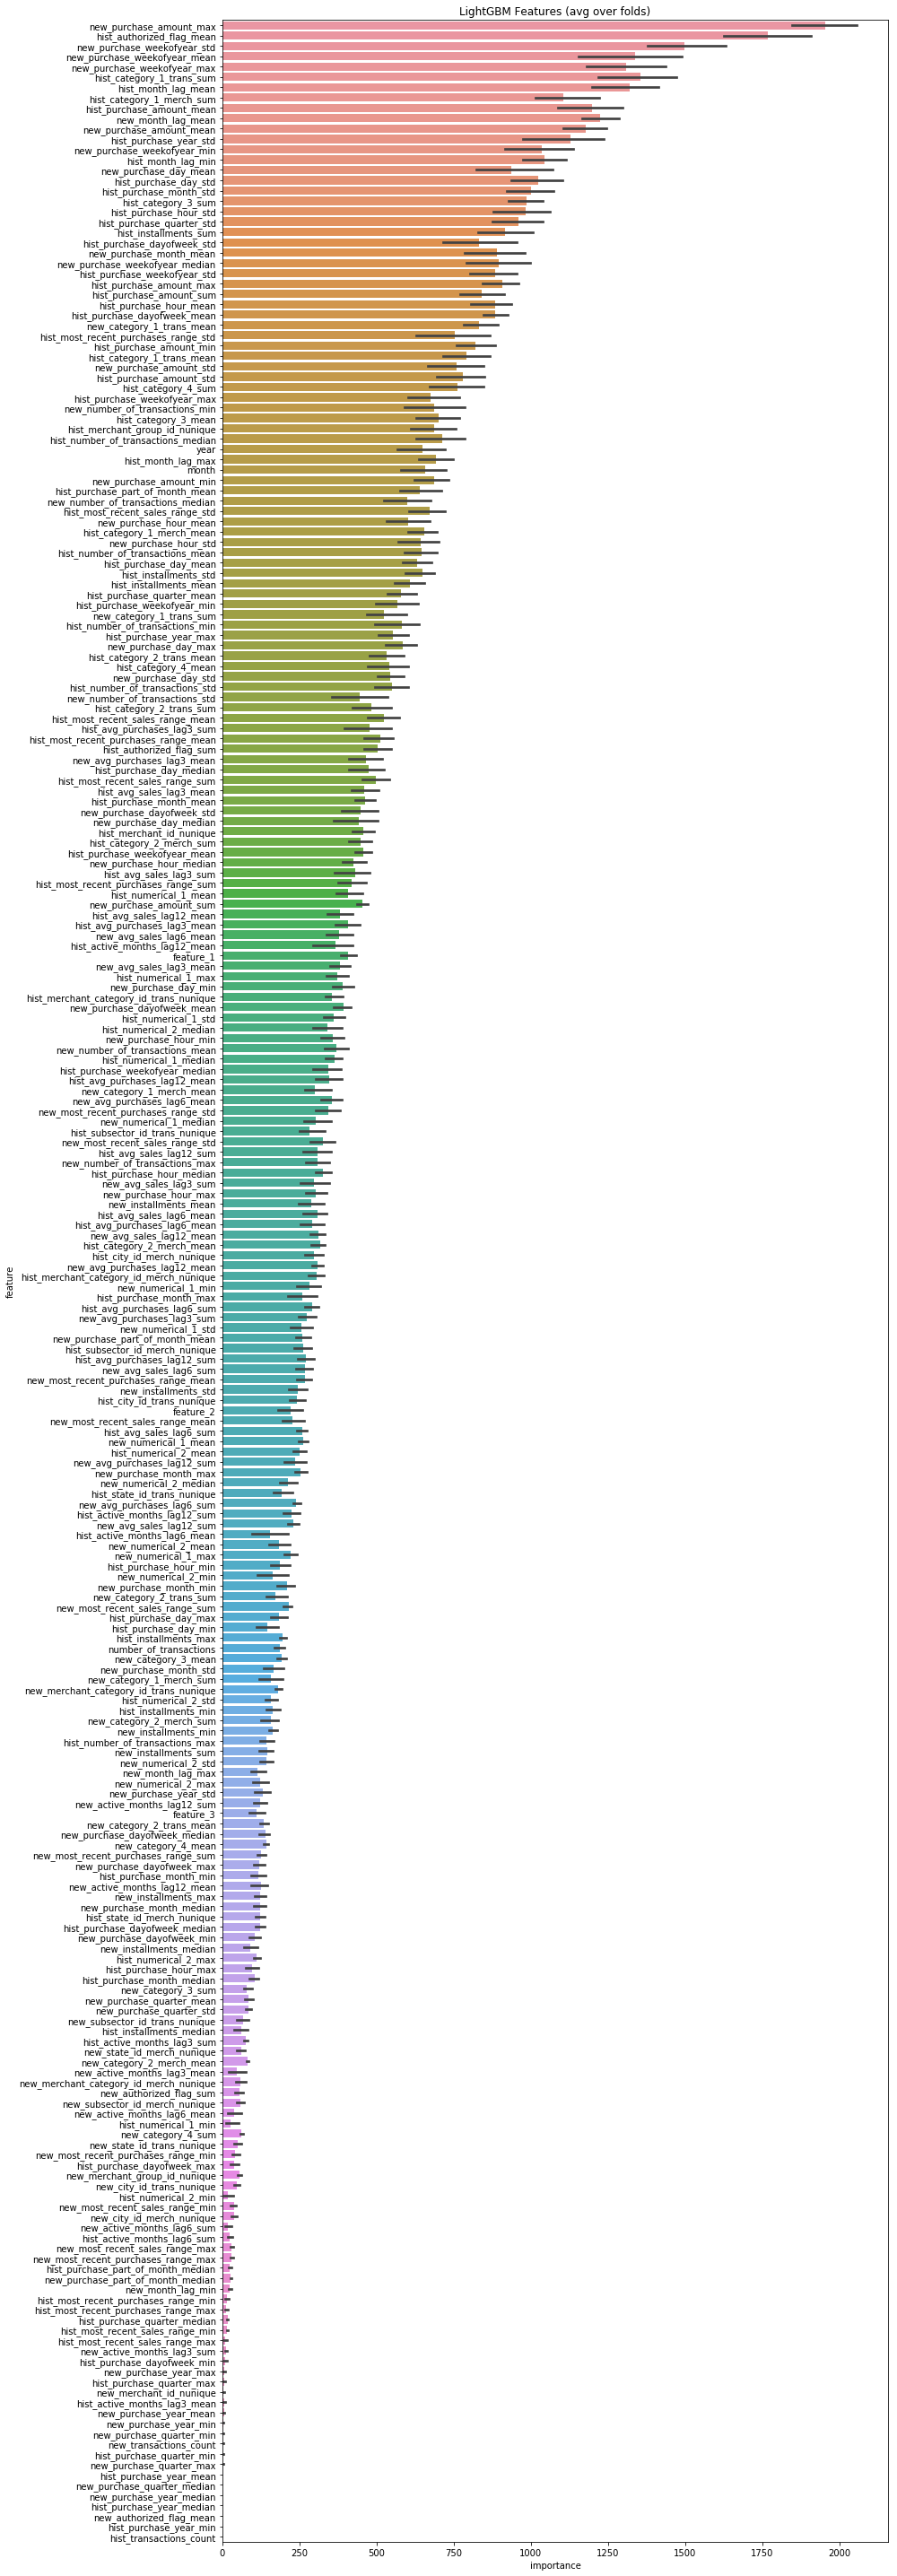

In [18]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [19]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("output/lgbm_{}.csv".format(cross_validation_lgb), index=False)